In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting

import astropy.constants as const
au = const.au.cgs.value
Msun = const.M_sun.cgs.value
Mearth = const.M_earth.cgs.value

In [2]:
def plot_scatter_and_hist(x, y, weights, x_lim=None, y_lim=None, plot_hists=True, color='tab:blue', figsize=4.3):
    x = np.array(x)[weights>0]
    y = np.array(y)[weights>0]
    w = weights[weights>0]
    
    main_panel_ratio = 0.75
    
    fig = plt.figure(figsize=(figsize,figsize))
    
    ax = fig.add_axes([0  ,0  ,main_panel_ratio,main_panel_ratio])
    plt.xscale('log')
    plt.yscale('log')
    set_ticks()
    a0 = 0.5
    a = a0*w
    import matplotlib
    c0 = matplotlib.colors.to_rgb(color)
    c = [c0+(a1,) for a1 in a]
    plt.scatter(x,y,c=c,edgecolor='None')
    
    if x_lim is None:
        x_lim = plt.xlim()
    else:
        plt.xlim(x_lim)
    if y_lim is None:
        y_lim = plt.ylim()
    else:
        plt.ylim(y_lim)
    
    if not plot_hists:
        return fig
    
    n_bins = 15
    
    ax = fig.add_axes([main_panel_ratio,0  ,1-main_panel_ratio, main_panel_ratio]) # y hist
    bins = np.logspace(np.log10(y_lim[0]), np.log10(y_lim[1]), n_bins)
    plt.hist(y, bins=bins, density=False, histtype='stepfilled', color='silver', orientation='horizontal')
    plt.ylim(y_lim)
    plt.yscale('log')
    plt.gca().set_yticklabels([])
    plt.xticks([])
    set_ticks()
    
    ax = fig.add_axes([0  ,main_panel_ratio,main_panel_ratio,1-main_panel_ratio]) # x hist
    bins = np.logspace(np.log10(x_lim[0]), np.log10(x_lim[1]), n_bins)
    plt.hist(x, bins=bins, density=False, histtype='stepfilled', color='silver')
    plt.xlim(x_lim)
    plt.xscale('log')
    plt.gca().set_xticklabels([])
    plt.yticks([])
    set_ticks()
    
    return fig

In [3]:
def diff_2D_gaussian(x, p):
    dy1sq, dy2sq, dy1dy2 = p[0], p[1], p[2]
    sig_maj, sig_min, th = x[0], x[1], x[2]
    d1 = (sig_maj**2*np.cos(th)**2+sig_min**2*np.sin(th)**2) - dy1sq
    d2 = (sig_maj**2*np.sin(th)**2+sig_min**2*np.cos(th)**2) - dy2sq
    d3 = (sig_maj**2*np.cos(th)*np.sin(th)-sig_min**2*np.cos(th)*np.sin(th)) - dy1dy2
    return np.array([d1,d2,d3])
import scipy.optimize
def solve_2D_gaussian(dy1sq, dy2sq, dy1dy2):
    sig_maj, sig_min, th = 1,1,np.pi/4
    x = scipy.optimize.fsolve(diff_2D_gaussian, [sig_maj, sig_min, th], args=[dy1sq, dy2sq, dy1dy2])
    return x
def plot_uncertainty_log_scale(dy1sq, dy2sq, dy1dy2, x0, y0):
    sig_maj, sig_min, th = solve_2D_gaussian(dy1sq, dy2sq, dy1dy2)
    th_grid = np.linspace(0, 2*np.pi, 100)
    x1 = np.cos(th_grid)*sig_maj
    y1 = np.sin(th_grid)*sig_min
    x2 = np.cos(th)*x1-np.sin(th)*y1
    y2 = np.sin(th)*x1+np.cos(th)*y1
    logx = np.log(x0) + x2
    logy = np.log(y0) + y2
    plt.fill(np.exp(logx), np.exp(logy), 'silver', alpha=.25, zorder=-1)

In [4]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5_alma_only.pkl','rb') as f:
    Ds_alma = np.array(pickle.load(f))
from get_chi_sq import get_mean_chisq_mult
chi_sq = get_mean_chisq_mult(Ds)
weights = np.zeros(len(chi_sq))
weights[chi_sq<=2] = (2-chi_sq)[chi_sq<=2]
weights[chi_sq<=1] = 1

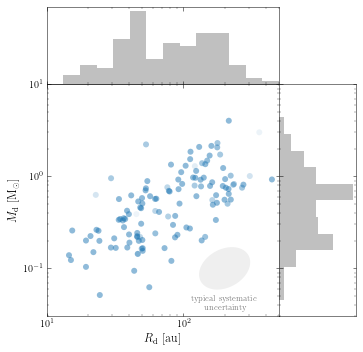

In [11]:
x = [D.disk_model.Rd/au for D in Ds]
y = [(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds]

fig = plot_scatter_and_hist(x,y,weights,(10,5e2),(0.03,10))
plt.sca(fig.axes[0])
plt.xlabel(r'$R_{\rm d}$ [au]')
plt.ylabel(r'$M_{\rm d}$ [M$_\odot$]')

dy1sq, dy2sq, dy1dy2 = 0.1853567950779059, 0.2822320360727028, 0.06589718869756671
plot_uncertainty_log_scale(dy1sq, dy2sq, dy1dy2, 200, 0.1)

plt.text(200, 0.05, 'typical systematic\nuncertainty', color='tab:grey', fontsize=8, weight='bold', ha='center', va='top')

plt.savefig('../figures/scatter_Rd_Md.pdf',bbox_inches='tight')

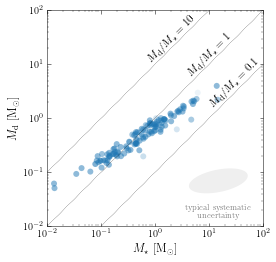

In [13]:
x = [D.disk_model.Mstar/Msun for D in Ds]
y = [(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds]

fig = plot_scatter_and_hist(x,y,weights,(0.01,100),(0.01,100), plot_hists=False, figsize=4)
plt.sca(fig.axes[0])
plt.xlabel(r'$M_{\star}$ [M$_\odot$]')
plt.ylabel(r'$M_{\rm d}$ [M$_\odot$]')
x = np.array([1e-2,1e2])
plt.plot(x,x,'k:',lw=.5)
plt.plot(x,x*10,'k:',lw=.5)
plt.plot(x,x*0.1,'k:',lw=.5)
plt.text(10,10*1.5,r'$M_{\rm d}/M_\star = 1$',rotation=45,ha='center',va='center')
plt.text(30,3*1.5,r'$M_{\rm d}/M_\star = 0.1$',rotation=45,ha='center',va='center')
plt.text(2,20*1.5,r'$M_{\rm d}/M_\star = 10$',rotation=45,ha='center',va='center')

dy1sq, dy2sq, dy1dy2 = 1.5744940391955033, 0.2822320360727028, 0.27173650979573905
plot_uncertainty_log_scale(dy1sq, dy2sq, dy1dy2, 15, 0.07)
plt.text(15, 0.025, 'typical systematic\nuncertainty', color='tab:grey', fontsize=8, weight='bold', ha='center', va='top')

#plt.savefig('../figures/scatter_Ms_Md.pdf',bbox_inches='tight')
plt.savefig('../figures_poster/mass_estimate.pdf',bbox_inches='tight')

median Md/Mstar: 0.8081143283633743


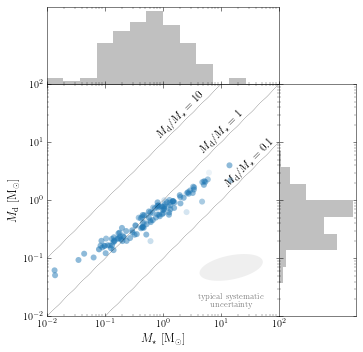

In [17]:
x = [D.disk_model.Mstar/Msun for D in Ds]
y = [(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds]

print('median Md/Mstar:',np.nanmedian(np.array(y)/x))

fig = plot_scatter_and_hist(x,y,weights,(0.01,100),(0.01,100), plot_hists=True)
plt.sca(fig.axes[0])
plt.xlabel(r'$M_{\star}$ [M$_\odot$]')
plt.ylabel(r'$M_{\rm d}$ [M$_\odot$]')
x = np.array([1e-2,1e2])
plt.plot(x,x,'k:',lw=.5)
plt.plot(x,x*10,'k:',lw=.5)
plt.plot(x,x*0.1,'k:',lw=.5)
plt.text(10,10*1.5,r'$M_{\rm d}/M_\star = 1$',rotation=45,ha='center',va='center')
plt.text(30,3*1.5,r'$M_{\rm d}/M_\star = 0.1$',rotation=45,ha='center',va='center')
plt.text(2,20*1.5,r'$M_{\rm d}/M_\star = 10$',rotation=45,ha='center',va='center')

dy1sq, dy2sq, dy1dy2 = 1.5744940391955033, 0.2822320360727028, 0.27173650979573905
plot_uncertainty_log_scale(dy1sq, dy2sq, dy1dy2, 15, 0.07)
plt.text(15, 0.025, 'typical systematic\nuncertainty', color='tab:grey', fontsize=8, weight='bold', ha='center', va='top')

plt.savefig('../figures/scatter_Ms_Md.pdf',bbox_inches='tight')

In [20]:
import astropy.table
data = astropy.table.Table.read("../data/VANDAM_T20_properties.txt", format="ascii")
data.add_index('Source') # add index by source

In [21]:
S22_tab1 = astropy.table.Table.read("../data/Sheehan_et_al_2022_tables/apjac574dt1_mrt.txt", format="ascii.cds")
S22_tab1.add_index('Sources')

163 163


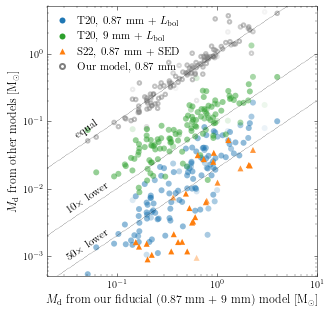

In [22]:
def get_vandam_Md(D):
    return data['MdiskA'][data.loc_indices[D.source_name]]*Mearth*100/Msun
def get_vandam_Md_V(D):
    return data['MdiskV'][data.loc_indices[D.source_name]]*Mearth*100/Msun
def get_vandam_Md_S22(D):
    i = 0
    try:
        i = S22_tab1.loc_indices[D.source_name]
        Md =  S22_tab1['Mdust'][i]*Mearth*100/Msun
    except:
        Md = np.nan
    return Md
    
x = [(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds]
y0 = [(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds_alma]
y1 = [get_vandam_Md(D) for D in Ds]
y2 = [get_vandam_Md_V(D) for D in Ds]
y3 = [get_vandam_Md_S22(D) for D in Ds]
print(len(Ds), len(y3))

x = np.array(x)[weights>0]
y0 = np.array(y0)[weights>0]
y1 = np.array(y1)[weights>0]
y2 = np.array(y2)[weights>0]
y3 = np.array(y3)[weights>0]
w = weights[weights>0]
a0 = 0.5
a = a0*w
import matplotlib

fig = plot_scatter_and_hist(x,y1,w,(2e-2,10),(5e-4,5), plot_hists=False, figsize=5)

c0 = matplotlib.colors.to_rgb('tab:green')
c = [c0+(a1,) for a1 in a]
plt.scatter(x,y2,c=c,edgecolor='None')

c0 = matplotlib.colors.to_rgb('tab:orange')
c = [c0+(a1,) for a1 in a*2]
plt.scatter(x,y3,c=c,edgecolor='None',marker='^')

c0 = matplotlib.colors.to_rgb('tab:grey')
c = [c0+(a1,) for a1 in a]
plt.scatter(x,y0,c='None',edgecolor=c,s=12,lw=2)


plt.sca(fig.axes[0])
plt.xlabel(r'$M_{\rm d}$ from our fiducial (0.87 mm + 9 mm) model [M$_\odot$]')
plt.ylabel(r'$M_{\rm d}$ from other models [M$_\odot$]')
x = np.array(plt.xlim())
xl = plt.xlim()
yl = plt.ylim()
th0 = np.arctan(np.log(xl[1]/xl[0])/np.log(yl[1]/yl[0])) * 180/np.pi
plt.plot(x,x/1,'k:',lw=.5)
plt.text(0.05,0.05*1.5,r'equal',rotation=th0,ha='center',va='center')
plt.plot(x,x/10,'k:',lw=.5)
plt.text(0.05,0.05*1.5/10,r'$10{\times}$ lower',rotation=th0,ha='center',va='center')
plt.plot(x,x/50,'k:',lw=.5)
plt.text(0.05,0.05*1.5/50,r'$50{\times}$ lower',rotation=th0,ha='center',va='center')

p1,=plt.plot([],[],'tab:blue',marker='o', ls='None', mec='None', alpha=1)
p2,=plt.plot([],[],'tab:green',marker='o', ls='None', mec='None', alpha=1)
p3,=plt.plot([],[],'tab:orange',marker='^', ls='None', mec='None', alpha=1)
p4,=plt.plot([],[],'tab:grey',marker='o', ls='None', mec='tab:grey', mew=2, mfc='None', ms=5, alpha=1)
plt.legend([p1,p2,p3,p4], [r'T20, 0.87 mm + $L_{\rm bol}$', r'T20, 9 mm + $L_{\rm bol}$', 'S22, 0.87 mm + SED', 'Our model, 0.87 mm' ], loc=2, frameon=False, handlelength=1)

plt.savefig('../figures/scatter_vandam_M.pdf',bbox_inches='tight')